# Ethnicity classifier with a Conv Net
A classifier to identify the ethnicity of a person's face. The core of the classifier machine is a Convolutional Net. 

In [7]:
__author__ = "Joann H. Tang, PhD"
__copyright__ = "Copyright 2018"
__email__ = "eagtang2007@gmail.com"
__status__ = "Prototype"

In [70]:
import keras
import keras.utils
from keras.models import Sequential
#Core layers
from keras.layers import Dense, Dropout, Activation, Flatten
#CNN layers
from keras.layers import SeparableConv2D, Conv2D, MaxPooling2D
from keras.models import model_from_json

import numpy as np
import pandas as pd
import h5py

import io,json

import sqlite3


from matplotlib import pyplot as plt
import cv2

#### Set the directory path

In [14]:
path = "/Users/huizhentang/Documents/Repos/Pet-projects/Ethnicity-Classifier/Datasets/"
save_path = "/Users/huizhentang/Documents/Repos/Pet-projects/Ethnicity-Classifier/"

#### Setting up parameters for the classifier¶

In [53]:
batch_size = 64
num_classes = 4
epochs = 30
dropout = 0.2

#### Load data

In [54]:
#Connect to the database. 
conn = sqlite3.connect(path + 'ethface.db')
cur = conn.cursor() 

#Load data from databse using pandas.read_sql_query. 
x = pd.read_sql_query("SELECT * FROM ethface_asian_features;", conn)
y = pd.read_sql_query("SELECT * FROM ethface_asian_labels;", conn)

#Close connection to database
cur.close() 
conn.close()

In [55]:
x.drop('index', axis=1, inplace=True)
y.drop('index', axis=1, inplace=True)
x = x.values #Convert dataframe to array
n = int(len(x[:,0])/(128*128))
x = np.reshape(x,(n,128,128,3), order='C')
y = y.values #Convert dataframe to array

#### Data formatting and normalization

In [56]:
#Ensuring data casting to the right data type
x = (x).astype('float32')
#Feature normalization
x /= 255
#Convert class vectors to binary class matrices¶
y = keras.utils.to_categorical(np.asarray(y), num_classes)

#### Splitting dataset into training, validation, and test set¶

In [57]:
def split_dataset(X,Y,p_train,p_val,p_test):
    """
    Randomly select a defined percentge of the dataset as train set 
    and divide the rest for validation set and test set 
   
    Arguments:
    X -- numpy array of feature data, here, they are the pixel values of images
    Y -- numpy array of label data
    p_train -- the percentage of the total dataset that assigned as training set
    p_train -- the percentage of the total dataset that assigned as validation set
    p_train -- the percentage of the total dataset that assigned as testing set
    
    Returns:
    x_train -- pixel values of images in the training set
    y_train -- labels of images in the training set
    x_val -- pixel values of images in the validation set
    y_val -- labels of images in the validation set
    x_test -- pixel values of images in the test set
    y_test -- labels of images in the test set

    """
    idx_train = np.random.randint(len(y[:,0]), size=round(len(y[:,0])*p_train))
    idx_val = np.random.randint(len(y[:,0]), size=round(len(y[:,0])*p_val))
    idx_test = np.random.randint(len(y[:,0]), size=round(len(y[:,0])*p_test))
    x_train = X[idx_train,:]
    y_train = Y[idx_train,:]
    x_val = X[idx_val,:]
    y_val = Y[idx_val,:]
    x_test = X[idx_test,:]
    y_test = Y[idx_test,:]
    return x_train, y_train, x_val, y_val, x_test, y_test

In [58]:
x_train,y_train,x_val,y_val,x_test,y_test=split_dataset(x,y,0.7,0.15,0.15)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(3145, 128, 128, 3)
(3145, 4)
(674, 128, 128, 3)
(674, 4)
(674, 128, 128, 3)
(674, 4)


#### Build a convolutional neural network

In [59]:
#Declare a sequential model
model = Sequential()
#CNN input layer 
model.add(SeparableConv2D(32, kernel_size =(3,3), 
                 activation='relu', 
                 depth_multiplier = 3,
                 padding = 'same',
                 input_shape=x_train.shape[1:]))

#Add hidden layers to the model 
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dropout))

#Fully connected Dense layers 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))

#### Generate model summary

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_2 (Separabl (None, 128, 128, 32)      401       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 64)        0         
__________

#### Compile model

In [61]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

#### Train the neural network model

In [62]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

Train on 3145 samples, validate on 674 samples
Epoch 1/30
3145/3145 [==============================] - 185s 59ms/step - loss: 1.5851 - acc: 0.2871 - val_loss: 1.3874 - val_acc: 0.2300
Epoch 2/30
3145/3145 [==============================] - 143s 45ms/step - loss: 1.3589 - acc: 0.3129 - val_loss: 1.3589 - val_acc: 0.3042
Epoch 3/30
3145/3145 [==============================] - 148s 47ms/step - loss: 1.3265 - acc: 0.3466 - val_loss: 1.3568 - val_acc: 0.3086
Epoch 4/30
3145/3145 [==============================] - 147s 47ms/step - loss: 1.3089 - acc: 0.3876 - val_loss: 1.3363 - val_acc: 0.3338
Epoch 5/30
3145/3145 [==============================] - 148s 47ms/step - loss: 1.2588 - acc: 0.4305 - val_loss: 1.2931 - val_acc: 0.3887
Epoch 6/30
3145/3145 [==============================] - 147s 47ms/step - loss: 1.2013 - acc: 0.4642 - val_loss: 1.2694 - val_acc: 0.3902
Epoch 7/30
3145/3145 [==============================] - 147s 47ms/step - loss: 1.1166 - acc: 0.5196 - val_loss: 1.2090 - val_acc: 0

#### Save model and weights

In [63]:
#Serialize model to JSON
model_json = model.to_json()
with io.open('model.json', 'w', encoding='utf-8') as json_file:
    json_file.write(model_json)

#Serialize weights to HDF5
model.save_weights(save_path + "model.h5")

print("Model saved to: " + save_path)

Model saved to: /Users/huizhentang/Documents/Repos/Pet-projects/Ethnicity-Classifier/


#### Load model and weights

In [64]:
#Load json and recreate model
with open(save_path + 'model.json') as json_file:
    trained_model = model_from_json(json_file.read())

#Load weights into new model
trained_model.load_weights('model.h5')

print("Loaded trained model")

Loaded trained model


#### Run evaluation on the trained model with the test set

In [65]:
trained_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
score = trained_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.16797035647
Test accuracy: 0.710682492582


#### Prediction 

In [74]:
print(path + '/Asian/Pred/' + str(n) +'*.jpg')

/Users/huizhentang/Documents/Repos/Pet-projects/Ethnicity-Classifier/Datasets//Asian/Pred/14*.jpg


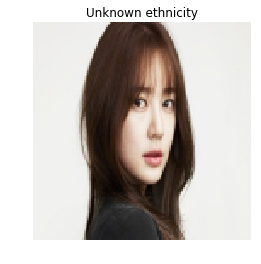

In [76]:
## # load and show image for ethnicity prediction
n = np.random.randint(1,80)
im_pred = cv2.imread(path + '/Asian/Pred/' + str(n) +'.jpg')
RGB_im_pred = cv2.cvtColor(im_pred, cv2.COLOR_BGR2RGB)
# Resize image to new size (width X height)
width = 128
height = 128
resized_im_pred = cv2.resize(RGB_im_pred, (width,height), interpolation = cv2.INTER_AREA)
plt.imshow(resized_im_pred)
plt.title('Unknown ethnicity')
plt.axis('off')
plt.show()

In [81]:
arr_x = np.zeros((1,width,height,3)) 
print(arr_x.shape)

(1, 128, 128, 3)


In [87]:
if im_pred is not None:
    arr = np.asarray(resized_im_pred)
arr_x[0,:] = arr
arr_x = (arr_x).astype('float32')
prediction = trained_model.predict(arr_x)[0]
print('Korean-Japanese-Chinese-Indian')
print(prediction)

Korean-Japanese-Chinese-Indian
[ 0.  1.  0.  0.]
